In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
import urllib.request, zipfile

url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = 'cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall()

train_dir = 'cats_and_dogs_filtered/train'
val_dir   = 'cats_and_dogs_filtered/validation'

In [ ]:
IMG_SIZE = (160,160)
BATCH = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH, label_mode='int'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH, label_mode='int'
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [ ]:

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE+(3,),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE+(3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = data_augmentation(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15,
                    callbacks=callbacks)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7488 - loss: 0.4877 - val_accuracy: 0.9740 - val_loss: 0.0991
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9550 - loss: 0.1373 - val_accuracy: 0.9810 - val_loss: 0.0703
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9747 - loss: 0.1012 - val_accuracy: 0.9830 - val_loss: 0.0568
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9714 - loss: 0.0811 - val_accuracy: 0.9850 - val_loss: 0.0504
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9677 - loss: 0.0886 - val_accuracy: 0.9870 - val_loss: 0.0481
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9701 - loss: 0.0836 - val_accuracy: 0.9840 - val_loss: 0.0455
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9676 - loss: 0.0759 - val_accuracy: 0.9830 - val_loss: 0.0460
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9708 - loss: 0.0713 - val_accuracy: 0.9850 - val_loss:

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.2f}")

model.save('final_image_classifier.keras')
print("Model saved as final_image_classifier.keras")


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 605ms/step - accuracy: 0.9911 - loss: 0.0336
Validation Accuracy: 0.99
Model saved as final_image_classifier.keras


In [ ]:
def predict_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    plt.imshow(img); plt.axis("off"); plt.show()

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)   # no preprocess_input here!

    pred = model.predict(img_array)
    print("Raw prediction value:", pred[0][0])
    conf = pred[0][0] if pred[0][0] > 0.5 else 1 - pred[0][0]
    print(f"Confidence: {conf*100:.2f}%")


    if pred[0][0] > 0.5:
        print("Prediction: Dog")
    else:
        print("Prediction:  Cat")



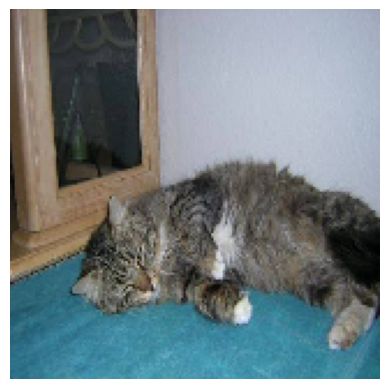

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Raw prediction value: 0.00018491519
Confidence: 99.98%
Prediction:  Cat


In [13]:
sample_path = os.path.join(val_dir, "cats", os.listdir(os.path.join(val_dir, "cats"))[15])
predict_image(sample_path)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_pred = []

# Loop over validation dataset
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())                       # true labels
    y_pred.extend((preds > 0.5).astype("int32").flatten())  # predicted labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report (precision, recall, f1-score)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

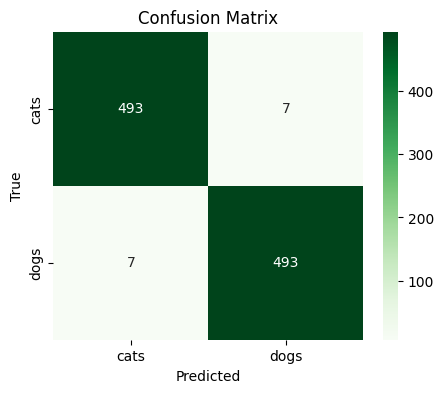

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

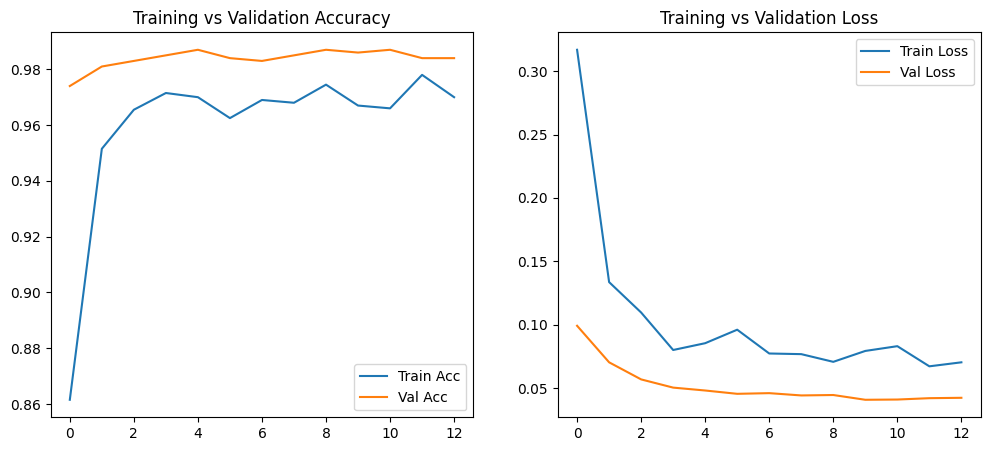

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")

plt.savefig("training_curves.png")  # saves to Colab files
plt.show()
